In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn, Tensor
import math
from glob import glob
import sys
import shutil  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


%matplotlib inline

In [ ]:
!pip install --upgrade --no-cache-dir gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14841 sha256=284dbc4420a7b4697832eee2b331f45203fd66a07db20035569e3caf8552289e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1pekz4n5/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [ ]:
url = "https://drive.google.com/drive/u/0/folders/1niDgB_OdWyXR6hpkfGA0OkdjlHodTj0g"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg',
 '/content/Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg',
 '/content/Cropped M

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Background' : [ 0, 0, 0],
                            'Inverted Channel' : [ 0, 0, 255]} # in BGR

        self.bin_classes = ['Background', 'Inverted Channel']


    def __getitem__(self, idx):
        
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        plt.imshow(mask)
        cls_mask = np.zeros(mask.shape)

        cls_mask[mask == self.BGR_classes['Background']] = self.bin_classes.index('Background')
        cls_mask[mask == self.BGR_classes['Inverted Channel']] = self.bin_classes.index('Inverted Channel')
        torch.set_printoptions(profile="full")
        #print("class mask",cls_mask)
        cls_mask = cls_mask[:,:,2] #removing nearby elements [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] -> [0,2,4,6,8]
        #print("---------------------------------------------------")
        #print(cls_mask)
        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)
            
            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512)) 
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [ ]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('./Cropped Martian Inverted Channels', training = True, transform= t)
print(dataset.IMG_NAMES)

len(dataset)

['./Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_020673_1750_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_031064_1760_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_035600_1765_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_039385_1760_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_048233_1770_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_053639_1760_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_055195_1735_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_071971_1760_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_072116_1740_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/ESP_072327_1750_RED.browse.jpg', './Cropped Martian Inverted Channels/Aeolis Dorsa/images/PSP_009623_1755_RED.browse.jpg', './Croppe

23

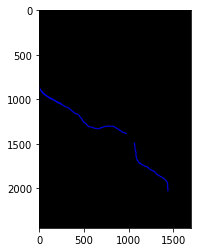

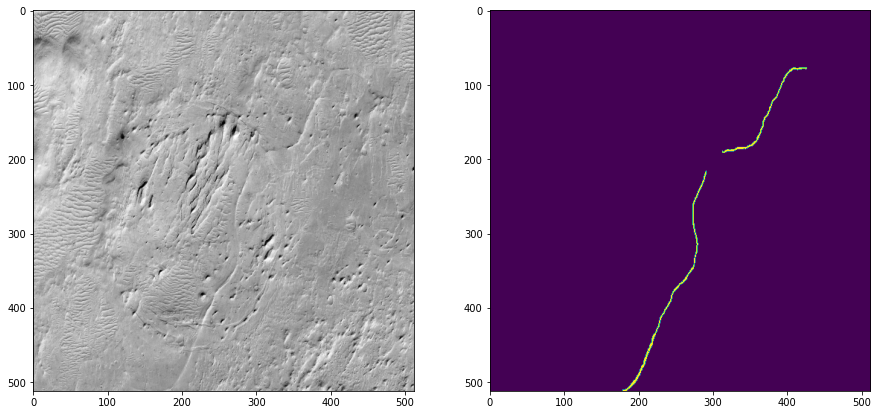

In [ ]:
d = dataset[1]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [ ]:
test_num = int(0.15 * len(dataset))
print(f'test data : {test_num}')
# Manual seed used to recreate the random split and get the same datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

test data : 3


In [ ]:
BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DropBlock(nn.Module):
    def __init__(self, block_size: int = 5, p: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.p = p

    def calculate_gamma(self, x: Tensor) -> float:
        """计算gamma
        Args:
            x (Tensor): 输入张量
        Returns:
            Tensor: gamma
        """

        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid

    def forward(self, x: Tensor) -> Tensor:
        N, C, H, W = x.size()
        if self.training:
            gamma = self.calculate_gamma(x)
            mask_shape = (N, C, H - self.block_size + 1, W - self.block_size + 1)
            mask = torch.bernoulli(torch.full(mask_shape, gamma, device=x.device))
            mask = F.pad(mask, [self.block_size // 2] * 4, value=0)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x1 = torch.mean(x, dim=1, keepdim=True)
        x2, _ = torch.max(x, 1, keepdim=True)
        x3 = torch.cat((x1, x2), dim=1)
        x4 = torch.sigmoid(self.conv(x3))
        x = x4 * x
        assert len(x.shape) == 4, f"好像乘不了"
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        self.attn = Attention()
        self.conv2 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
                                   DropBlock(7, 0.9),
                                   nn.BatchNorm2d(512),
                                   nn.ReLU(inplace=True)
                                   )

        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.attn(x5)
        x7 = self.conv2(x6)
        #x = self.up1(x6, x4)
        x = self.up1(x7, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        #print("logits", logits.size())
        #print("out ", logits.size())
        return logits

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, Tensor


class DropBlock(nn.Module):
    def __init__(self, block_size: int = 5, p: float = 0.1):
        super().__init__()
        self.block_size = block_size
        self.p = p

    def calculate_gamma(self, x: Tensor) -> float:
        """计算gamma
        Args:
            x (Tensor): 输入张量
        Returns:
            Tensor: gamma
        """

        invalid = (1 - self.p) / (self.block_size ** 2)
        valid = (x.shape[-1] ** 2) / ((x.shape[-1] - self.block_size + 1) ** 2)
        return invalid * valid

    def forward(self, x: Tensor) -> Tensor:
        N, C, H, W = x.size()
        if self.training:
            gamma = self.calculate_gamma(x)
            mask_shape = (N, C, H - self.block_size + 1, W - self.block_size + 1)
            mask = torch.bernoulli(torch.full(mask_shape, gamma, device=x.device))
            mask = F.pad(mask, [self.block_size // 2] * 4, value=0)
            mask_block = 1 - F.max_pool2d(
                mask,
                kernel_size=(self.block_size, self.block_size),
                stride=(1, 1),
                padding=(self.block_size // 2, self.block_size // 2),
            )
            x = mask_block * x * (mask_block.numel() / mask_block.sum())
        return x


class DoubleConv(nn.Sequential):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        if mid_channels is None:
            mid_channels = out_channels
        super(DoubleConv, self).__init__(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.9),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__(
            nn.MaxPool2d(2, stride=2),
            DoubleConv(in_channels, out_channels)
        )


class Last_Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super(Last_Down, self).__init__(
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            DropBlock(7, 0.18),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        # 原论文采用的是转置卷积，我们一般用双线性插值
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:  # 采用转置卷积的通道数会减少一半
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # [N, C, H, W]
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]
        # 为了防止maxpooling后得到的图片尺寸向下取整，不是整数倍
        # padding_left, padding_right, padding_top, padding_bottom
        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Sequential):
    def __init__(self, in_channels, num_classes):
        super(OutConv, self).__init__(
            nn.Conv2d(in_channels, num_classes, kernel_size=1),
#             nn.Sigmoid(),
        )


class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
        x1 = torch.mean(x, dim=1, keepdim=True)
        x2, _ = torch.max(x, 1, keepdim=True)
        x3 = torch.cat((x1, x2), dim=1)
        x4 = torch.sigmoid(self.conv(x3))
        x = x4 * x
        assert len(x.shape) == 4, f"好像乘不了"
        return x


class SA_UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 3,
                 num_classes: int = 1,
                 bilinear: bool = False,
                 base_c: int = 16):
        super(SA_UNet, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.bilinear = bilinear

        self.conv1 = DoubleConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down3 = Last_Down(256, 512 // factor)
        #self.down4 = Down(512, 1024 // factor)

        self.attn = Attention()
        self.conv2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
                                   DropBlock(7, 0.9),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True)
                                   )

        #self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.out_conv = OutConv(64, num_classes)

    def forward(self, x):
        #print("x shape ",x.size())
        x1 = self.conv1(x)
        #print("x1 shape ",x1.size())
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        #print("x3 shape ",x3.size())
        x4 = self.down3(x3)
        #print("x4 shape ",x4.size())
        #x5 = self.down4(x4)
        #print("x5 shape ",x5.size())
        x6 = self.attn(x4)
        x7 = self.conv2(x6)
        #print("x6 shape ",x6.size())
        #print("x7 shape ",x7.size())
        #x = self.up1(x6, x4)
        #x = self.up1(x7, x4)
        #print("x shape in up1 ",x.size())
        x = self.up2(x7, x3)
        #print("x shape in up2 ",x.size())
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.out_conv(x)

        return logits


if __name__ == "__main__":
    model = SA_UNet()


In [ ]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W
        #print("Input ",inputs)
        #print("inputs", inputs.size())
        N = inputs.size()[0]
        #N = 4

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)
        #a = inputs[0][0][123][12]
        #b = inputs[0][1][123][12]
       # print(a)
       # print(b)
        #print(a + b)

        #print(target.size())
        #print(type(inputs[0][1]))
        #inputs = inputs[0][1]
        #savingMask = torch.flatten(inputs)
        #np.savetxt('my_file2.txt', savingMask.detach().numpy())
        
        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        #target_oneHot = target_oneHot[0][1]
       # print(target_oneHot.size())
        #c = inputs[0][0][123][12]
       # d = inputs[0][1][123][12]
        #print(c)
        #print(d)
        #print(c + d)
        inter = inputs * target_oneHot
        #print("inter size", inter.size())
        total = 0
        for imageInd in range(N):
          #print(imageInd)
          total += inter[imageInd][1].view(-1).sum()

        inter = total

        #print(inter.size())
        ## Sum over all pixels N x C x H x W => N x C
        #print(inter.view(N,self.classes,-1).size())
        #print(inter.view(N,self.classes,-1).sum(2))
        #print(inter)
        #inter = inter.view(N,self.classes,-1).sum(2)

        #print(inter)


        #Denominator 
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C

        total2 = 0
        for imageInd in range(N):
          total2 += union[imageInd][1].view(-1).sum()

        union = total2

        #union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [ ]:
criterion = mIoULoss(n_classes=2).to(device)

In [ ]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [ ]:
min_loss = torch.tensor(float('inf'))

#model = UNet(n_channels=3, n_classes=2, bilinear=True).to(device)
model = SA_UNet(in_channels=3, num_classes=2, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
from pprint import pprint
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 50
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0
prediction = []

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      #torch.set_printoptions(profile="full")
      #pprint(pred_mask)
      #
      #np.savetxt('my_file.txt', pred_mask.detach().numpy())
      #savingMask = F.softmax(pred_mask, dim = 1)
      #savingMask = torch.flatten(pred_mask)
      #np.savetxt('my_file1.txt', savingMask.detach().numpy())
      #torch.save(savingMask, 'file2.txt')

      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():    
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())
    
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
                                                                                                 np.mean(loss_list), 
                                                                                                 np.mean(acc_list), 
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])
  #print("prediction ", prediction.size(), prediction.data[0])
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/50] [Batch 4/5] [Loss: 0.972694 (0.974634)] epoch 0 - loss : 0.97463 - acc : 0.50 - val loss : 0.95472 - val acc : 0.95
[Epoch 1/50] [Batch 4/5] [Loss: 0.973975 (0.970794)] epoch 1 - loss : 0.97079 - acc : 0.59 - val loss : 0.95718 - val acc : 0.73
[Epoch 2/50] [Batch 4/5] [Loss: 0.967482 (0.971948)] epoch 2 - loss : 0.97195 - acc : 0.64 - val loss : 0.95793 - val acc : 0.95
[Epoch 3/50] [Batch 4/5] [Loss: 0.982300 (0.968058)] epoch 3 - loss : 0.96806 - acc : 0.68 - val loss : 0.96161 - val acc : 0.95
[Epoch 4/50] [Batch 4/5] [Loss: 0.954677 (0.968669)] epoch 4 - loss : 0.96867 - acc : 0.70 - val loss : 0.95067 - val acc : 0.70
[Epoch 5/50] [Batch 4/5] [Loss: 0.949045 (0.964577)] epoch 5 - loss : 0.96458 - acc : 0.76 - val loss : 0.94991 - val acc : 0.94
[Epoch 6/50] [Batch 4/5] [Loss: 0.952810 (0.967390)] epoch 6 - loss : 0.96739 - acc : 0.75 - val loss : 0.94516 - val acc : 0.95
[Epoch 7/50] [Batch 4/5] [Loss: 0.958110 (0.962108)] epoch 7 - loss : 0.96211 - acc : 0.76 - val 

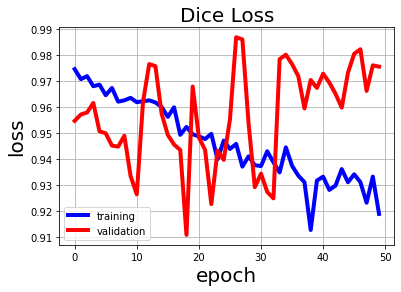

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('Dice Loss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/saved_models/unet_epoch_10_0.92636.pt'))

<All keys matched successfully>

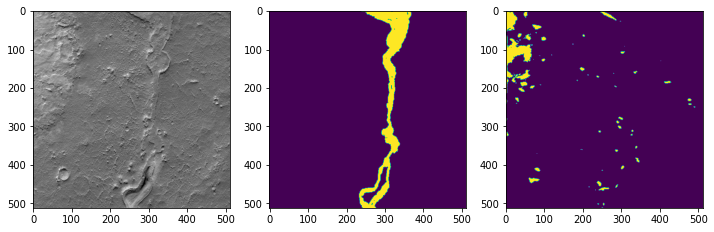

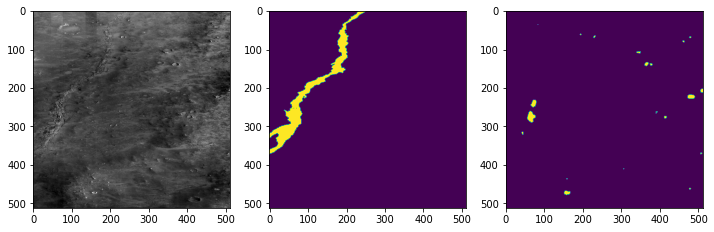

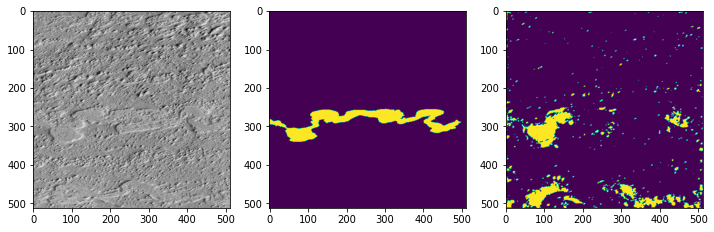

In [ ]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

In [ ]:
a = torch.randn(1, 2, 3, 3)
a

In [ ]:
a.view(-1)

In [ ]:
model.state_dict()